# Colormaps

This Jupyter Notebook describes the rationale for developing the `ehtplot.color` submodule in `ehtplot`.  Before we get into the actual content, let's customize Jupyter so this notebook is easier to read and use.

In [1]:
from IPython.core.display import display, HTML, Javascript 

# Display text with 16px fonts
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

# Disable cell scrolling
display(Javascript("IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }"))

# Enable autoreload for easy module developement
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## 0. Contents:
<a id="sec0"></a>

- [0. Contents](#sec0)
- [1. Background](#sec1)
- [2. Basic Requirements](#sec2)
- [3. Color Models and Color Spaces](#sec3)
- [4. Color Appearance Parameters](#sec4)
- [5. General Guidance](#sec5)
- [6. Colormap Inspectation](#sec6)

## 1. Background
<a id="sec1"></a>

The [Event Horizon Telescope (EHT)](https://eventhorizontelescope.org/) is a Very-long-baseline interferometry (VLBI) experiment aiming at capture of the first pictures of black holes.  While an image worth a thousand words, the interpretation of an image is subjective.  The presentation of an image can strongly affect how human eyes identify features.  This is especially true for two-dimensional intensity maps, where the value of each pixel is represented by a color.  A poorly chosen colormap between values and colors can fool the human eyes to, e.g., pick out non-existing features, or to hide important features.

In order to present the resulting images of the EHT as accurate as possible, we take into account how human eyes work and provide a few guidance on the colormap usages in different situations.

## 2. Basic Requirements
<a id="sec2"></a>

Without putting in too much details, a good colormap for scientific representation of a scalar image should:

1. give readers a correct sense on the scalar values (intensities) in the image;

2. not artificially show features that do not exist;

3. not intentionally hide features that exist;

4. be effective in communicating scientific messages;

5. be device-independent.

We summerize some works on human visual perceptual and standards created by the [International Commission on Illumination (ICE)](https://en.wikipedia.org/wiki/International_Commission_on_Illumination) below.  We will then use these basic knowledge to derive general guidance on deriving and using colormaps.

## 3. Color Models and Color Spaces
<a id="sec3"></a>

The "raw" [RGB](https://en.wikipedia.org/wiki/RGB_color_model) and [CMYK](https://en.wikipedia.org/wiki/CMYK_color_model) [color models](https://en.wikipedia.org/wiki/Color_model) are device-dependent.  In order to describe device-independent color, companies create "standardized" [color spaces](https://en.wikipedia.org/wiki/Color_space) such as [sRGB](https://en.wikipedia.org/wiki/SRGB) (standard RGB by HP and Microsoft) and [Adobe RGB](https://en.wikipedia.org/wiki/Adobe_RGB_color_space). A [color profile](https://en.wikipedia.org/wiki/ICC_profile), either characterizes a device or a color space, can then be used to accurately map the color in an image to a device.

The [CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space) (also CIE L\*a\*b\*, hereafter Lab) color space, introduced by the CIE in 1976, was the first attempt to take into account the the perceptual aspects of human vision.  Here, L\* is the lightness; a\* and b\* are the green-red and blue-yellow color components.  The [CIECAM02](https://en.wikipedia.org/wiki/CIECAM02) [color appearance model (CAM)](https://en.wikipedia.org/wiki/Color_appearance_model) published by the CIE in 2002 defines six color appearances: brightness Q, lightness J, colorfulness M, chroma C, saturation s, and hue h.  And the [iCAM06](https://en.wikipedia.org/wiki/Color_appearance_model#iCAM06) model is capable of handling spatial appearance phenomena such as contrast.

In 2006, [Luo et al.](https://www.researchgate.net/publication/229879898_Uniform_colour_spaces_based_on_CIECAMO2_colour_appearance_model) introduced three modifications to CIECAM02 to make it more uniform.  The CAM02-UCS, stands for "Uniform Colour Space", is not popular in computer graphics.  Its three coordinates are usually denoted by J', a', and b'.  And its cylindrical coordinates are J', C', and h'.

It is useful to transform the Cartesian Lab and CIECAM02 color spaces to the cylindrical [CIELCh](https://en.wikipedia.org/wiki/CIELAB_color_space#Cylindrical_representation:_CIELCh_or_CIEHLC) (hereafter LCh) and CIEJCh (hereafter JCh) color spaces which has coordinates L\*, J\*, C\*, and h. The lightness coordinates L\* and J\* are identical to Lab and Jab.  The chroma (relative saturation) C\* and hue h (in degree h°) are simply `C* = sqrt(a*^2 + b*^2)` and `h = atan2(b*, a*)` according to Redness-Greenness a and Yellowness-Blueness b in their own coordinates.

## 4. Color Appearance Parameters
<a id="sec4"></a>

We ignore spatial appearance phenomena and consider only the the six color appearance parameters defined by CIECAM02.  They can be grouped into three classes, correspond to the three coordinates of LCh:

- [Brightness](https://en.wikipedia.org/wiki/Brightness) and   [lightness](https://en.wikipedia.org/wiki/Lightness): they are the   extrinsic and intrinsic "tones" or "values", respectively.

- [Colorfulness](https://en.wikipedia.org/wiki/Colorfulness), [chroma](https://en.wikipedia.org/wiki/Colorfulness#Chroma_in_CIE_1976_L*a*b*_and_L*u*v*_color_spaces), and [saturation](https://en.wikipedia.org/wiki/Colorfulness#Saturation): colorfulness and chroma are, roughly speaking, the extrinsic and intrinsic difference between a color and grey of an object, respectively.  Saturation is the colorfulness of a color relative to its own brightness.

- [Hue](https://en.wikipedia.org/wiki/Hue): "the degree to which a stimulus can be described as similar to or different from stimuli that are described as red, green, blue, and yellow."  [Q: are the CIELCh hue and (s)RGB hue `h_rgb = atan2(sqrt(3) * (G-B), 2*R - G - B)` equivalent?]

It is important to note that the above terms can be defined very differently in different context.  For example, RGB brightness is defined as `(R + G + B) / 3`, which is completely different than CIECAM02 brightness.

## 5. General Guidance
<a id="sec5"></a>

In response to the above requirements, at minimal,

- we need to use *perceptually uniform colormaps*

so that the lightness of the color in an image is a fair representation of its scalar values.  While visual perception is a complex science, the CAM02-UCS lightnesses J' should serve us as a good approximation for generating perceptually uniform colormaps.  In fact, linearity in J' is used as the working definition of Perceptually Uniform Sequential colormaps by [matplotlib](https://matplotlib.org/users/colormaps.html).

Since chrominance is a two-dimensional quantity, we can use the different dimensions for different purposes.  Being independent of lightness and chroma and easily recognized,

- *hue h' can encode an additional physical quantity* in an image (when used in this way, the change of hue should be linearly proportional to the quantity);

- *hue h' is also ideal in making an image more attractive* without interferencing the representation of pixel values.

The other dimension chroma is less recognizable and should not be used to encode physical information.  Since sRGB is only a subset of the Lab colorspace, there are human regonizable color that are not displayable.  In order to accurately represent the physical quantities,

- if a color is not displayable, one should preserve its lightness J' and hue h', and adjust its chroma C'.

- *saturation s' is also useful to place focus of an image* without affecting the representation of the physical quantities.

Given that human eyes are less sensitive to color in low light,

- if color is used to encode an additional physical quantity in a figure, the *colormap may start (or end) at non-zero lightness*.

Finally, sRGB is often the default image color space for modern softwares.  That is, if we save an image without a color profile, it is often interpreted as in sRGB with [gamma](https://en.wikipedia.org/wiki/Gamma_correction) 2.2.  Therefore, we should

- convert colormaps to sRGB with gamma 2.2, and then save the resulting images without any color profile.

## 6. Colormap Inspectation
<a id="sec6"></a>

With all the above discussion, we are finally at a point to look into colormaps.  Let's first load up matplotlib and find out what colormaps are available:

In [2]:
import matplotlib.pyplot as plt

colormaps = plt.colormaps()
for cm in colormaps:
    print(cm, end=', ')
print("{} colormaps in total".format(len(colormaps)))

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2,

There are 164 built-in colormaps.  Most of them are actually not perceptually uniform.

To visualize them, let's load up the `ehtplot.color` submodule.

In [3]:
import ehtplot as ep

colormaps = plt.colormaps()
print("{} colormaps in total".format(len(colormaps)))

346 colormaps in total


The advanced color adjustment functions of `ehtplot.color` are only exposed if the `colorspacious` module is installed on your system.  Hence, `colorspacious` is required if you want to run the following code live.  Nevertheless, the number of colormaps available now becomes 346.  `ehtplot.color` provides 182 uniformized colormaps, which are accessible even without `colorspacious`.

To check the uniformality of a colormap, let's define a plotting function with helps from `ehtplot.color`

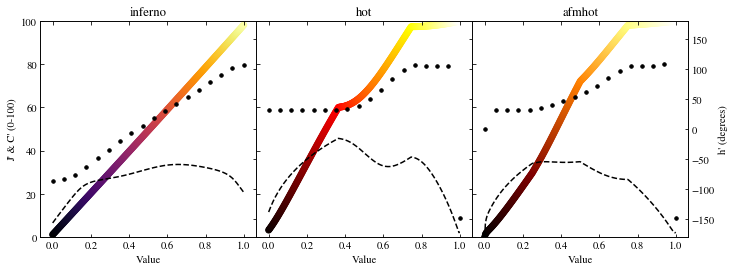

In [4]:
import numpy as np

from ehtplot.color import vis as ev

def plotcm(ax1, cmap):
    ctab = ev.get_ctab(cmap)  # get the colormap as a color table in sRGB
    Jabp = ev.transform(ctab) # transform color table into CAM02-UCS color space

    Jp = Jabp[:,0]
    ap = Jabp[:,1]
    bp = Jabp[:,2]

    Cp = np.sqrt(ap * ap + bp * bp)
    hp = np.arctan2(bp, ap) * 180 / np.pi
    v  = np.linspace(0.0, 1.0, len(Jp))

    ax1.set_title(cmap)
    ax1.set_xlabel("Value")

    ax2 = ax1.twinx()
    ax1.set_ylim(0,   100)
    ax1.set_ylabel("J' & C' (0-100)")
    ax2.set_ylim(-180,180)
    ax2.set_ylabel("h' (degrees)")
    
    ax1.scatter(v, Jp, color=ctab)
    ax1.plot   (v, Cp, c='k', linestyle='--')
    ax2.scatter(v[::15], hp[::15], s=12, c='k')
    
fig = ep.Figure(plotcm, ['inferno', 'hot', 'afmhot'], figsize=[9, 3])
fig.draw()

We look at two popular warm colormaps above: `hot` and `afmhot`.  The colorful curves are the lightness J', the black dashed lines are the chroma C', and the black dotted lines are the hue h'.  It is clear that niether colormaps are uniform (linear) in J'.  Also, niether of them is in a single color---they actually transite from red to yellow in different ways.  Finally, the `hot` colormap's chroma curve is not even bi-tonic.

To see how good/bad these colormaps are, let's load up some componets of a Principal Component Analysis (PCA) of a numerical simulation of a black hole (see [Medeiros et al. 2018](http://adsabs.harvard.edu/abs/2018ApJ...864....7M)) and plot them in the `hot` and `afmhot` colormaps.

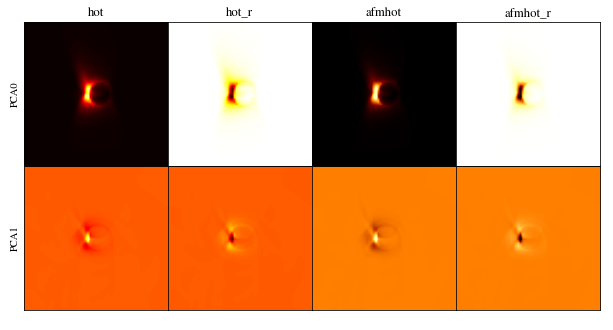

In [5]:
from ehtplot.extra import io

pca0 = io.open("../examples/sample", component="pca0")
pca1 = io.open("../examples/sample", component="pca1")

def plotimg(ax, img, cmap, label=None):
    vmax = np.max(img)
    vmin = np.min(img)
    if vmin >= 0.0:
        vmin = 0.0
    else:
        vmin = -max(vmax, -vmin)

    ax.imshow(img, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title(cmap)
    
top = ep.Panel(plotimg, pca0, ['hot', 'hot_r', 'afmhot', 'afmhot_r'], title='PCA0')
bot = ep.Panel(plotimg, pca1, ['hot', 'hot_r', 'afmhot', 'afmhot_r'], title='PCA1')
fig = ep.Figure(bot, top, inrow=False, figsize=[8, 4])
fig.draw()

The panels above plot the same images (0th PCA component in top row, 1st PCA component in bottom row) in `hot`, `hot_r`, `afmhot`, and `afmhot_r`.  The `_r` colormaps are simply reversed of their non-`_r` counter parts.

Although the accretion funnel, shown in light yellow, is difficult to see in both `hot_r` and `afmhot_r`, it is still more visible compare to `hot` and `afmhot`.  This is a direct consequence of our eyes being less sensitve to color in dim light.

Non-uniformality in ligthness can also lead to fault feature extractions.  To demonstrate it, we create a pyramid function and plot it with different colormaps.  In the ideal seituation, our eyes should only pick out the corners in the pyramid.  That is, we should pick out a cross "X" in the image, in addition to the color gradient.

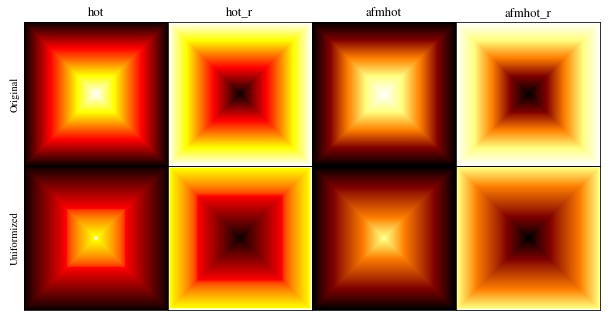

In [6]:
pyramid = ev.pyramid()

top = ep.Panel(plotimg, pyramid, ['hot', 'hot_r', 'afmhot', 'afmhot_r'],       title='Original')
bot = ep.Panel(plotimg, pyramid, ['hot_u', 'hot_ur', 'afmhot_u', 'afmhot_ur'], title='Uniformized')
fig = ep.Figure(bot, top, inrow=False, figsize=[8, 4])
fig.draw()

The top row shows the visualization using matplotlib's built-in colormaps.  We artificually see red and yellow squares in them.  If we go back to the J'(v) plots, we can identical these sqaures come from features in J'.

The bottom row shows the same function using `ehtplot`'s uniformized colormaps.  While some features can still be identified in `hot` and `hot_r` because of the peaks in the chroma C' curve, they are much better compoare to the top row.  In fact, the uniformized `afmhot_u` map `afmhot_ur` shows almost no sqaure feature.